In [35]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras

from keras.preprocessing import image
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from tensorflow.keras.layers import *
from tensorflow.keras import layers , models, optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.utils import plot_model



In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [159]:
train_dir = "./drive/Shareddrives/Deep Learning/archive.zip (Unzipped Files)/train"
test_dir = "./drive/Shareddrives/Deep Learning/archive.zip (Unzipped Files)/test"

### **Data preparation**



***1. Visualization of dataset ***

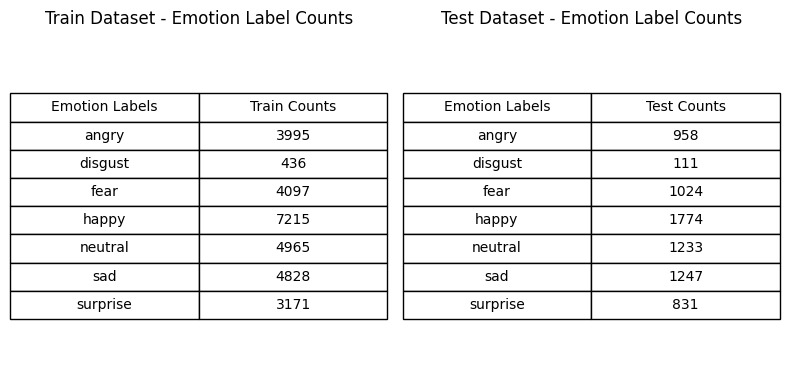

In [171]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def classes_count(path, dataset_name):
    classes_dict = {}
    for class_name in os.listdir(path):
        full_path = os.path.join(path, class_name)
        classes_dict[class_name] = len(os.listdir(full_path))
    result = {dataset_name: classes_dict}
    return result


train_count = classes_count(train_dir, 'Train')
test_count = classes_count(test_dir, 'Test')

# Extracted class names and counts number of images for train and test datasets
class_names_train = list(train_count['Train'].keys())
class_counts_train = list(train_count['Train'].values())


class_names_test = list(test_count['Test'].keys())
class_counts_test = list(test_count['Test'].values())


train_df = pd.DataFrame({'Emotion Labels': class_names_train, 'Train Counts': class_counts_train})
test_df = pd.DataFrame({'Emotion Labels': class_names_test, 'Test Counts': class_counts_test})


plt.figure(figsize=(8, 4))

# Train Dataset Table
plt.subplot(1, 2, 1)
table_data_train = [train_df.columns] + train_df.values.tolist()
table = plt.table(cellText=table_data_train, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
plt.axis('off')
plt.title('Train Dataset - Emotion Label Counts')

# Test Dataset Table
plt.subplot(1, 2, 2)
table_data_test = [test_df.columns] + test_df.values.tolist()
table = plt.table(cellText=table_data_test, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
plt.axis('off')
plt.title('Test Dataset - Emotion Label Counts')

plt.tight_layout()
plt.show()

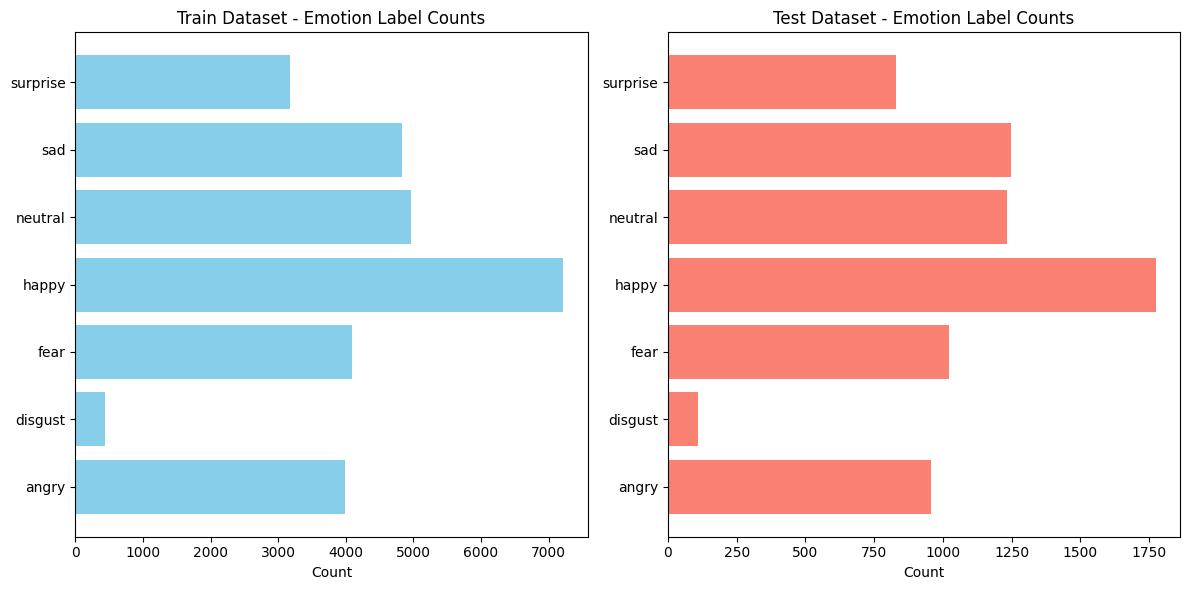

In [172]:
# Plot bar charts
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.barh(class_names_train, class_counts_train, color='skyblue')
plt.xlabel('Count')
plt.title('Train Dataset - Emotion Label Counts')

plt.subplot(1, 2, 2)
plt.barh(class_names_test, class_counts_test, color='salmon')
plt.xlabel('Count')
plt.title('Test Dataset - Emotion Label Counts')

plt.tight_layout()
plt.show()


**2. Subset Selection**

In [50]:
img_size = 224
batch_size = 64

In [51]:
#Data augmentation
train_datagen = ImageDataGenerator(
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale=1./255)


# We added subset selection that gets 10000 images from train_dir and 4000 images from test_dir
# Then splitted train images into validation and train subsets

# Training and Validation Data subset
images = []
labels = []

for sub_dir in os.listdir(train_dir):
    image_list = os.listdir(os.path.join(train_dir, sub_dir))
    image_list = list(map(lambda x: os.path.join(sub_dir, x), image_list))
    images.extend(image_list)
    labels.extend([sub_dir] * len(image_list))

df_train = pd.DataFrame({"Images": images, "Labels": labels})
df_train = df_train.sample(frac=1).reset_index(drop=True)  # Shuffle the data
df_train = df_train.head(10000)  # Take a subset of data (1000 samples)

print(df_train)

train_generator_subset=train_datagen.flow_from_dataframe(dataframe=df_train,
                                                  directory=train_dir,
                                                  x_col="Images",
                                                  y_col="Labels",
                                                  batch_size=batch_size,
                                                  color_mode="rgb",
                                                  class_mode="categorical",
                                                  subset="training",
                                                  target_size=(img_size, img_size))


validation_generator_subset = validation_datagen.flow_from_dataframe(dataframe=df_train,
                                                  directory=train_dir,
                                                  x_col="Images",
                                                  y_col="Labels",
                                                  batch_size=batch_size,
                                                  color_mode="rgb",
                                                  class_mode="categorical",
                                                  subset="validation",
                                                  target_size=(img_size, img_size))



# Test Data subset
images = []
labels = []

for sub_dir in os.listdir(test_dir):
    image_list = os.listdir(os.path.join(test_dir, sub_dir))
    image_list = list(map(lambda x: os.path.join(sub_dir, x), image_list))
    images.extend(image_list)
    labels.extend([sub_dir] * len(image_list))

df_test = pd.DataFrame({"Images": images, "Labels": labels})
df_test = df_test.sample(frac=1).reset_index(drop=True)  # Shuffle the data
df_test = df_test.head(4000)

test_generator_subset = test_datagen.flow_from_dataframe(dataframe=df_test,
                                                  directory=test_dir,
                                                  x_col="Images",
                                                  y_col="Labels",
                                                  batch_size=batch_size,
                                                  color_mode="rgb",
                                                  class_mode="categorical",
                                                  target_size=(img_size, img_size))

                             Images   Labels
0       happy/Training_74863333.jpg    happy
1       happy/Training_57472618.jpg    happy
2      neutral/Training_8970577.jpg  neutral
3       happy/Training_75082441.jpg    happy
4     neutral/Training_93514240.jpg  neutral
...                             ...      ...
9995    happy/Training_21165220.jpg    happy
9996     fear/Training_55602615.jpg     fear
9997     fear/Training_80866611.jpg     fear
9998    happy/Training_99956118.jpg    happy
9999    angry/Training_54676031.jpg    angry

[10000 rows x 2 columns]
Found 8000 validated image filenames belonging to 7 classes.
Found 2000 validated image filenames belonging to 7 classes.
Found 4000 validated image filenames belonging to 7 classes.


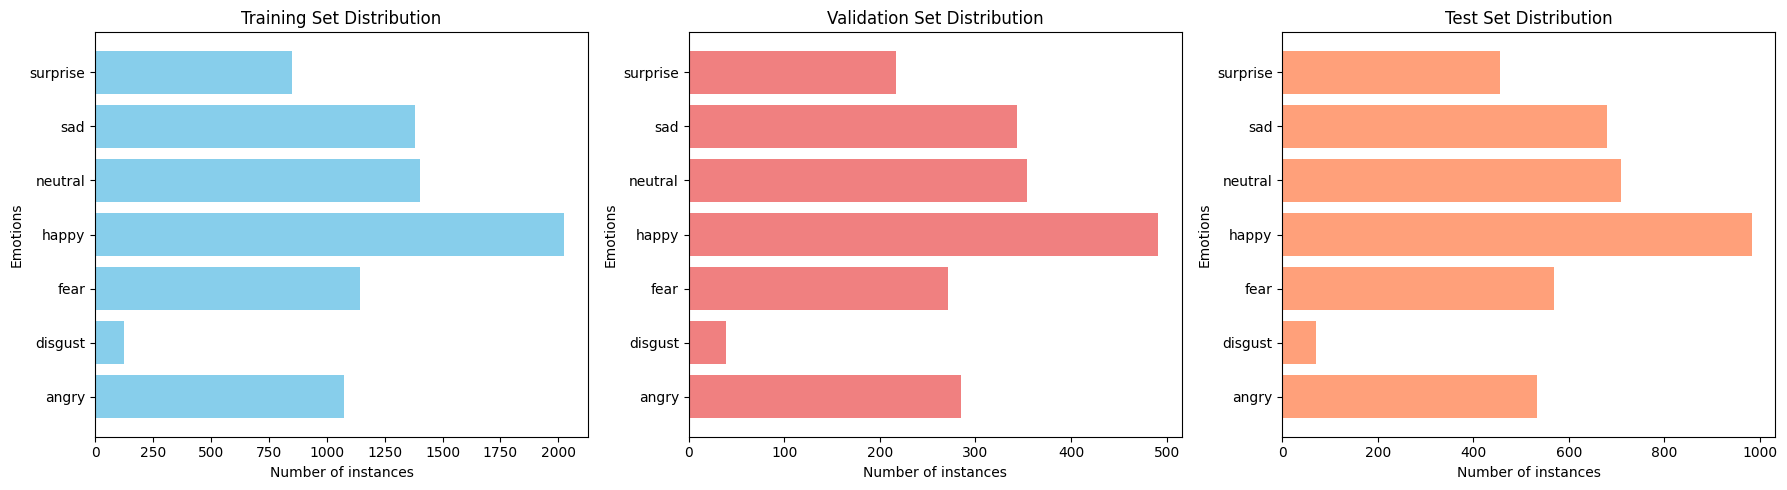

In [21]:

class_indices = train_generator_subset.class_indices
class_names = {v: k for k, v in class_indices.items()}

# Training set
class_counts_train = train_generator_subset.classes
unique_train, counts_train = np.unique(class_counts_train, return_counts=True)

# Validation set
class_counts_val = validation_generator_subset.classes
unique_val, counts_val = np.unique(class_counts_val, return_counts=True)

# Test set
class_counts_test = test_generator_subset.classes
unique_test, counts_test = np.unique(class_counts_test, return_counts=True)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Training set subplot
axes[0].barh([class_names[i] for i in unique_train], counts_train, color='skyblue')
axes[0].set_title('Training Set Distribution')
axes[0].set_xlabel('Number of instances')
axes[0].set_ylabel('Emotions')

# Validation set subplot
axes[1].barh([class_names[i] for i in unique_val], counts_val, color='lightcoral')
axes[1].set_title('Validation Set Distribution')
axes[1].set_xlabel('Number of instances')
axes[1].set_ylabel('Emotions')

# Test set subplot
axes[2].barh([class_names[i] for i in unique_test], counts_test, color='lightsalmon')
axes[2].set_title('Test Set Distribution')
axes[2].set_xlabel('Number of instances')
axes[2].set_ylabel('Emotions')

plt.tight_layout()
plt.show()


**Balanced Dataset**

We tried creating balanced dataset by determining miminum number of images from label and obtaining the same number of images from th rest categories

In [65]:
from collections import defaultdict

# Function to count images per emotion category
def count_images_per_category(directory):
    counts = defaultdict(int)
    for sub_dir in os.listdir(directory):
        counts[sub_dir] = len(os.listdir(os.path.join(directory, sub_dir)))
    return counts


train_counts = count_images_per_category(train_dir)
test_counts = count_images_per_category(test_dir)

# Determined the minimum number of images among labels
min_images_per_category_train = min(train_counts.values())
min_images_per_category_test = min(test_counts.values())

# Created balanced dataframes for train, validation and test
train_images = []
train_labels = []
test_images = []
test_labels = []

for sub_dir in os.listdir(train_dir):
    image_list = os.listdir(os.path.join(train_dir, sub_dir))
    image_list = list(map(lambda x: os.path.join(sub_dir, x), image_list))
    train_images.extend(image_list[:min_images_per_category_train])
    train_labels.extend([sub_dir] * min_images_per_category_train)

for sub_dir in os.listdir(test_dir):
    image_list = os.listdir(os.path.join(test_dir, sub_dir))
    image_list = list(map(lambda x: os.path.join(sub_dir, x), image_list))
    test_images.extend(image_list[:min_images_per_category_test])
    test_labels.extend([sub_dir] * min_images_per_category_test)

df_train_balanced = pd.DataFrame({"Images": train_images, "Labels": train_labels})
df_train_balanced = df_train_balanced.sample(frac=1).reset_index(drop=True)

df_test_balanced = pd.DataFrame({"Images": test_images, "Labels": test_labels})
df_test_balanced = df_test_balanced.sample(frac=1).reset_index(drop=True)



train_generator_subset2 = train_datagen.flow_from_dataframe(
    dataframe=df_train_balanced,
    directory=train_dir,
    x_col="Images",
    y_col="Labels",
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical",
    subset="training",
    target_size=(img_size, img_size)
)

validation_generator_subset2 = validation_datagen.flow_from_dataframe(
    dataframe=df_train_balanced,
    directory=train_dir,
    x_col="Images",
    y_col="Labels",
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical",
    subset="validation",
    target_size=(img_size, img_size)
)

test_generator_subset2 = test_datagen.flow_from_dataframe(
    dataframe=df_test_balanced,
    directory=test_dir,
    x_col="Images",
    y_col="Labels",
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical",
    target_size=(img_size, img_size)
)

Found 2442 validated image filenames belonging to 7 classes.
Found 610 validated image filenames belonging to 7 classes.
Found 777 validated image filenames belonging to 7 classes.


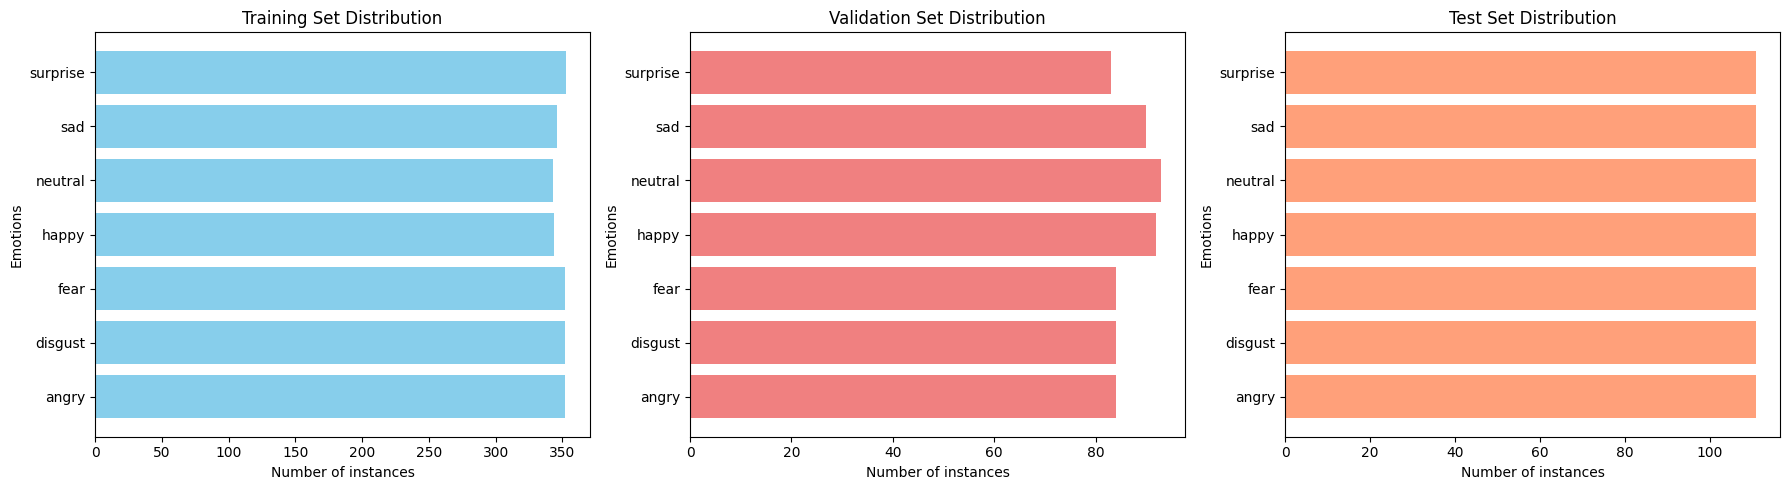

In [98]:
class_indices = train_generator_subset2.class_indices
class_names = {v: k for k, v in class_indices.items()}

# Training set
class_counts_train = train_generator_subset2.classes
unique_train, counts_train = np.unique(class_counts_train, return_counts=True)

# Validation set
class_counts_val = validation_generator_subset2.classes
unique_val, counts_val = np.unique(class_counts_val, return_counts=True)

# Test set
class_counts_test = test_generator_subset2.classes
unique_test, counts_test = np.unique(class_counts_test, return_counts=True)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Training set subplot
axes[0].barh([class_names[i] for i in unique_train], counts_train, color='skyblue')
axes[0].set_title('Training Set Distribution')
axes[0].set_xlabel('Number of instances')
axes[0].set_ylabel('Emotions')

# Validation set subplot
axes[1].barh([class_names[i] for i in unique_val], counts_val, color='lightcoral')
axes[1].set_title('Validation Set Distribution')
axes[1].set_xlabel('Number of instances')
axes[1].set_ylabel('Emotions')

# Test set subplot
axes[2].barh([class_names[i] for i in unique_test], counts_test, color='lightsalmon')
axes[2].set_title('Test Set Distribution')
axes[2].set_xlabel('Number of instances')
axes[2].set_ylabel('Emotions')

plt.tight_layout()
plt.show()


In [66]:
#Function for plotting acc and loss during training
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

  #plt.tight_layout()

### **Baseline Model**

The baseline model is taken from https://www.kaggle.com/code/aayushmishra1512/emotion-detector
The model reports final train accuracy = 71.73 , validation accuracy = 65.22 for entire dataset

In [111]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
basemodel= tf.keras.models.Sequential()
basemodel.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
basemodel.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
basemodel.add(BatchNormalization())
basemodel.add(MaxPool2D(pool_size=(2, 2)))
basemodel.add(Dropout(0.25))

basemodel.add(Conv2D(128,(5,5), padding='same', activation='relu'))
basemodel.add(BatchNormalization())
basemodel.add(MaxPool2D(pool_size=(2, 2)))
basemodel.add(Dropout(0.25))

basemodel.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
basemodel.add(BatchNormalization())
basemodel.add(MaxPool2D(pool_size=(2, 2)))
basemodel.add(Dropout(0.25))

basemodel.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
basemodel.add(BatchNormalization())
basemodel.add(MaxPool2D(pool_size=(2, 2)))
basemodel.add(Dropout(0.25))

basemodel.add(Flatten())
basemodel.add(Dense(256,activation = 'relu'))
basemodel.add(BatchNormalization())
basemodel.add(Dropout(0.25))

basemodel.add(Dense(512,activation = 'relu'))
basemodel.add(BatchNormalization())
basemodel.add(Dropout(0.25))

basemodel.add(Dense(7, activation='softmax'))

basemodel.compile(
    optimizer = Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

basemodel.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_26 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 24, 24, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_35 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 128)     

### **Our  model**

# Training with unbalanced dataset

In [58]:
def Create_Custom_Model():
    # we took pretrained ResNet-50 as a base
    base_model = tf.keras.applications.ResNet50V2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )

   # freezed all weights except last 50 layers
    for layer in base_model.layers[:-50]:
        layer.trainable = False


  # added FC layers and softmax with dropouts and BN
    model = tf.keras.Sequential([

        base_model,
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(7, activation='softmax')
    ])

    return model

ResNet50V2_Model = Create_Custom_Model2()
ResNet50V2_Model.summary()
ResNet50V2_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


#created chekpoint for the model
checkpoint_path = "Improved_ResNet50V2_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Created Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 6, restore_best_weights = True, verbose=1)

# Created ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
                                                   min_lr=0.000005,
                                                  verbose=1)

callbacks = [Reducing_LR,Early_Stopping]


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout_23 (Dropout)        (None, 7, 7, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense_24 (Dense)            (None, 128)               12845184  
                                                                 
 batch_normalization_16 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_24 (Dropout)        (None, 128)               0         
                                                      

In [59]:
#Training on unbalanced dataset
ResNet50V2_Model_history = ResNet50V2_Model.fit(
    train_generator_subset,
    validation_data=validation_generator_subset,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
125/125 [==============================] - 1486s 12s/step - loss: 1.8815 - accuracy: 0.3626 - val_loss: 4.5138 - val_accuracy: 0.4640 - lr: 0.0010
Epoch 2/50
125/125 [==============================] - 135s 1s/step - loss: 1.3817 - accuracy: 0.4906 - val_loss: 1.3454 - val_accuracy: 0.5355 - lr: 0.0010
Epoch 3/50
125/125 [==============================] - 136s 1s/step - loss: 1.2487 - accuracy: 0.5418 - val_loss: 1.2158 - val_accuracy: 0.5630 - lr: 0.0010
Epoch 4/50
125/125 [==============================] - 136s 1s/step - loss: 1.1537 - accuracy: 0.5844 - val_loss: 1.3260 - val_accuracy: 0.5410 - lr: 0.0010
Epoch 5/50
125/125 [==============================] - 134s 1s/step - loss: 1.0648 - accuracy: 0.6151 - val_loss: 1.1610 - val_accuracy: 0.5985 - lr: 0.0010
Epoch 6/50
125/125 [==============================] - 138s 1s/step - loss: 1.0088 - accuracy: 0.6344 - val_loss: 1.2843 - val_accuracy: 0.5595 - lr: 0.0010
Epoch 7/50
125/125 [==============================] - ETA: 0s 

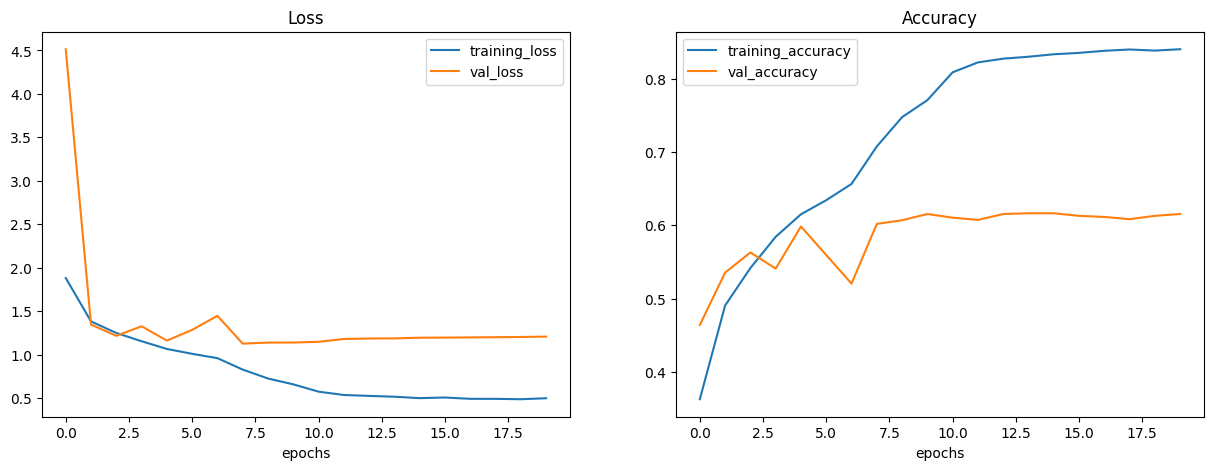

In [60]:
#Loss and accuracy plots for validation and train
plot_curves(ResNet50V2_Model_history)

### **Results**

**1. Confusion matrix**

63/63 [==============================] - 13s 208ms/step


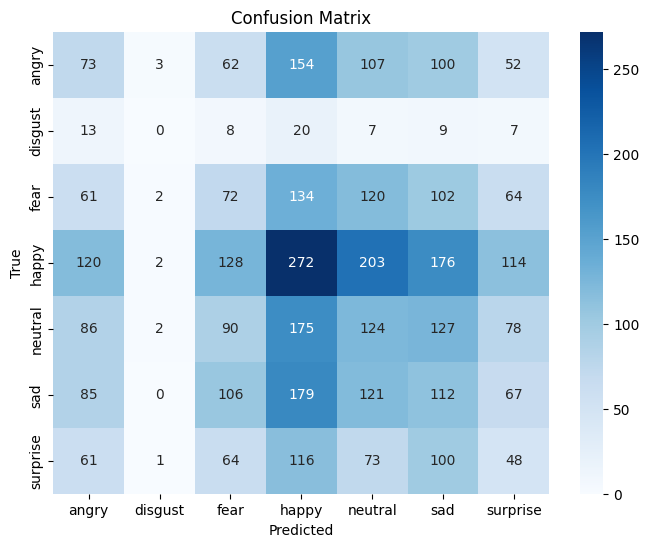

In [108]:
from sklearn.metrics import confusion_matrix

predictions = ResNet50V2_Model.predict(test_generator_subset)
y_true = test_generator_subset.classes
y_pred = np.argmax(predictions, axis=1)


#confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_generator_subset.class_indices,
            yticklabels=train_generator_subset.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



**2. T-SNE visualization**

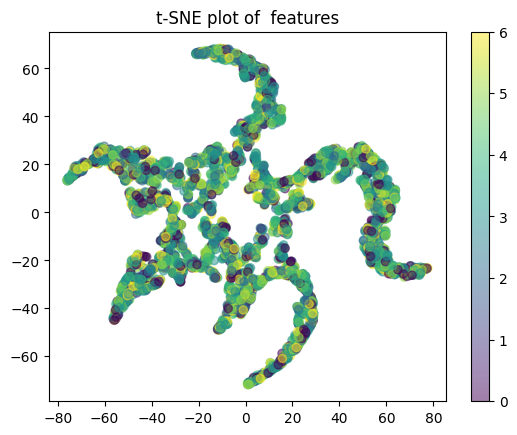

In [109]:
from sklearn.manifold import TSNE
#Plotting t-SNE for our features
intermediate_output = predictions
tsne = TSNE(n_components=2, random_state=42)
basic_test_images_tsne = tsne.fit_transform(intermediate_output)


plt.scatter(
    basic_test_images_tsne[:, 0],
    basic_test_images_tsne[:, 1],
    c=(test_generator_subset.classes),
    cmap='viridis',
    alpha=0.5
)
plt.colorbar()
plt.title('t-SNE plot of  features')
plt.show()


**3. Random prediction**

In [112]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_dir,
    class_mode="categorical",
    target_size=(224,224),
    color_mode="rgb",
    shuffle=True,   # Shuffling Test Data to show diffrent classes
    batch_size=batch_size,
)
Emotion_Classes = ['Angry',
                  'Disgust',
                  'Fear',
                  'Happy',
                  'Neutral',
                  'Sad',
                  'Surprise']

Found 7178 images belonging to 7 classes.


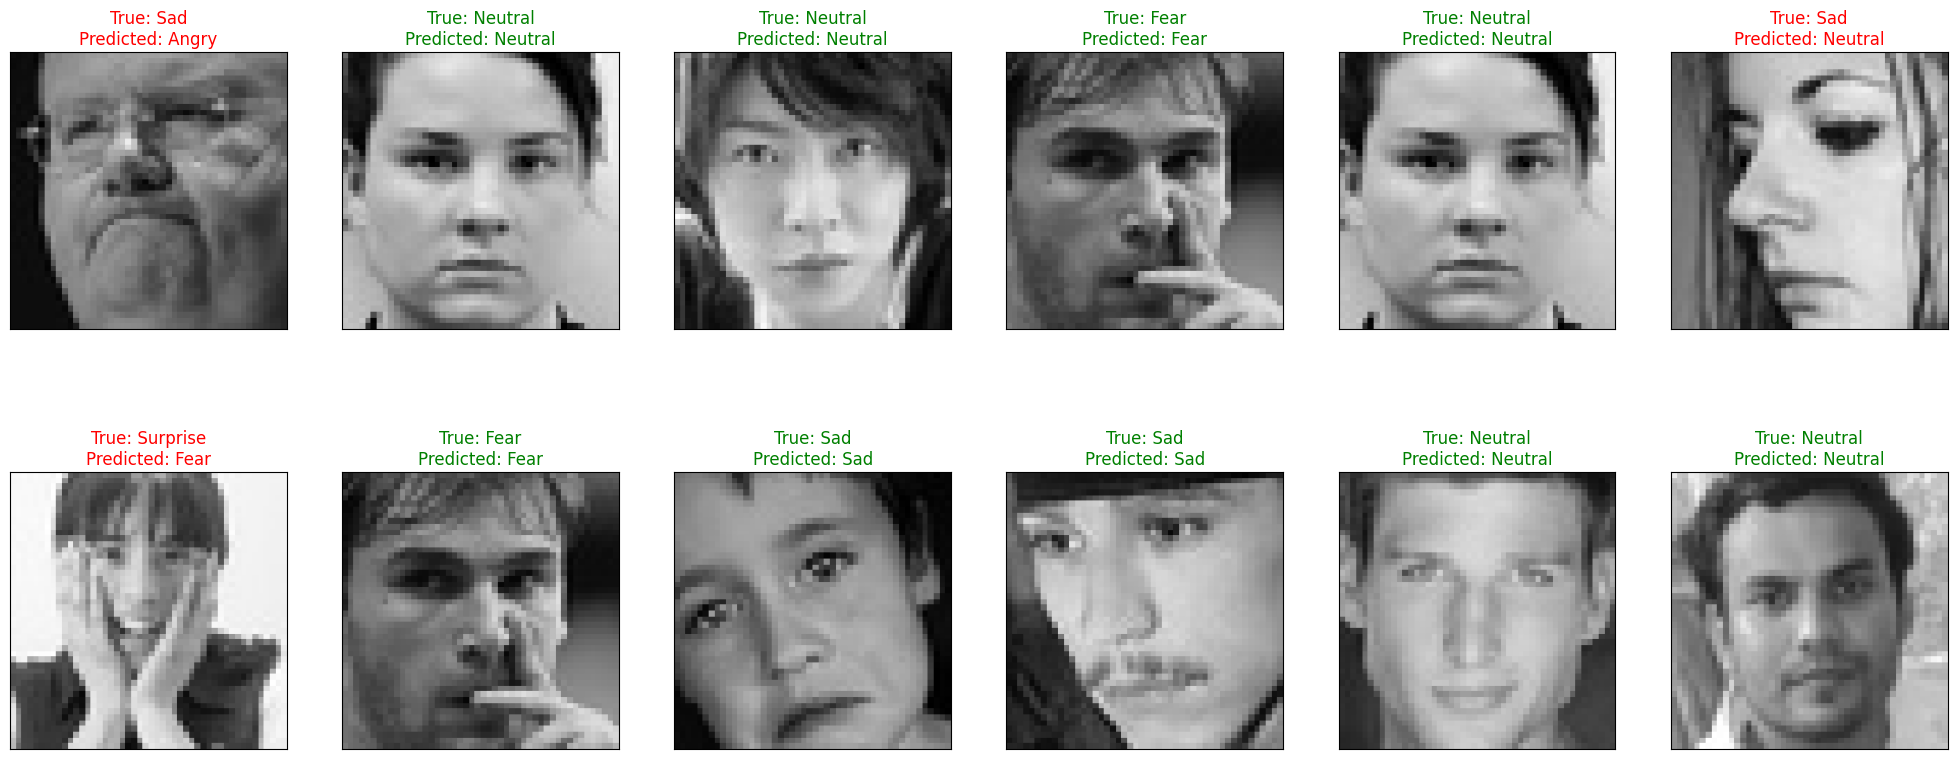

<Figure size 640x480 with 0 Axes>

In [87]:
#Predicting random 12 images
Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Index = np.random.randint(0, batch_size - 1 , 12)

fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Index[i]])

    Model_Prediction = np.argmax(ResNet50V2_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()

**Final Accuracy**

In [88]:
train_loss, train_acc = ResNet50V2_Model.evaluate(train_generator_subset)
test_loss, test_acc = ResNet50V2_Model.evaluate(test_generator_subset)
print("final train accuracy = {:.2f} , test accuracy = {:.2f}".format(train_acc*100, test_acc*100))

63/63 [==============================] - 13s 198ms/step - loss: 1.1161 - accuracy: 0.6342
final train accuracy = 86.12 , test accuracy = 63.42


## Training on balanced data

In [67]:
ResNet50V2_Model2 = Create_Custom_Model2()
ResNet50V2_Model2.summary()
ResNet50V2_Model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


#created chekpoint for the model
checkpoint_path = "ResNet50V2_Model2_Balanced_Checkpoint"

Checkpoint2 = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Created Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 6, restore_best_weights = True, verbose=1)

# Created ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
                                                   min_lr=0.000005,
                                                  verbose=1)

callbacks = [Reducing_LR,Early_Stopping]

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout_26 (Dropout)        (None, 7, 7, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_27 (Dense)            (None, 128)               12845184  
                                                                 
 batch_normalization_18 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_27 (Dropout)        (None, 128)               0         
                                                      

In [69]:
#Model training on balanced subset
ResNet50V2_Model2_history = ResNet50V2_Model2.fit(
    train_generator_subset2,
    validation_data=validation_generator_subset2,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
39/39 [==============================] - 260s 7s/step - loss: 1.7551 - accuracy: 0.3694 - val_loss: 2.3498 - val_accuracy: 0.3918 - lr: 0.0010
Epoch 2/50
39/39 [==============================] - 48s 1s/step - loss: 1.5482 - accuracy: 0.4111 - val_loss: 1.6311 - val_accuracy: 0.4361 - lr: 0.0010
Epoch 3/50
39/39 [==============================] - 44s 1s/step - loss: 1.4269 - accuracy: 0.4762 - val_loss: 1.5453 - val_accuracy: 0.4656 - lr: 0.0010
Epoch 4/50
39/39 [==============================] - 50s 1s/step - loss: 1.2961 - accuracy: 0.5152 - val_loss: 1.5321 - val_accuracy: 0.4803 - lr: 0.0010
Epoch 5/50
39/39 [==============================] - 49s 1s/step - loss: 1.2559 - accuracy: 0.5545 - val_loss: 2.0420 - val_accuracy: 0.3459 - lr: 0.0010
Epoch 6/50
39/39 [==============================] - ETA: 0s - loss: 1.3129 - accuracy: 0.5295
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
39/39 [==============================] - 53s 1s/step - loss: 1.

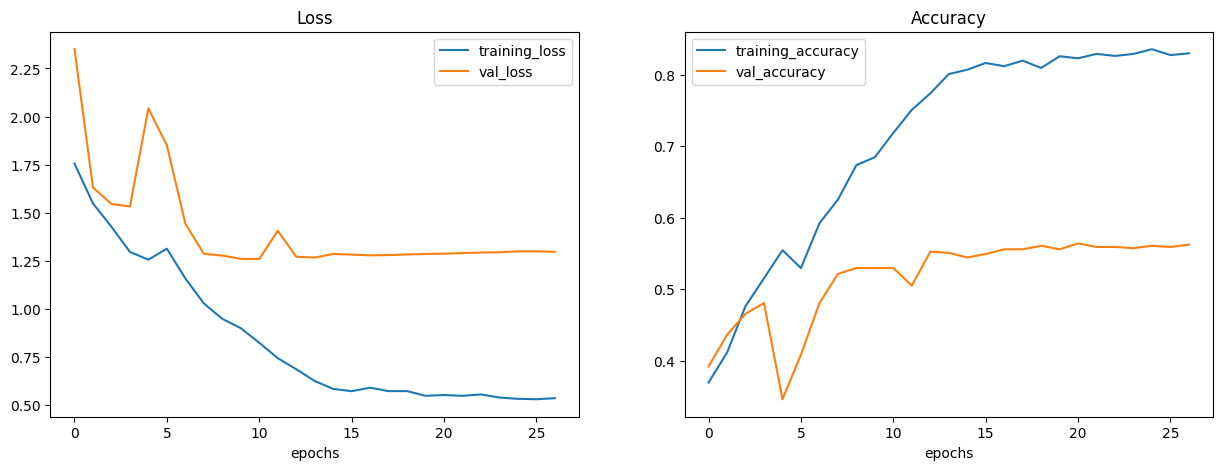

In [89]:
#Loss and accuracy plots for validation and train
plot_curves(ResNet50V2_Model2_history)

### **Results for balanced subset trained model**

**1. Confusion matrix**

13/13 [==============================] - 2s 183ms/step


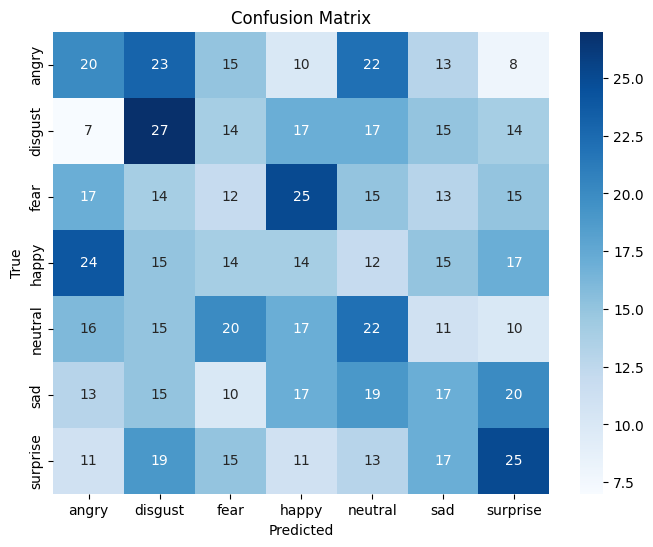

In [148]:
from sklearn.metrics import confusion_matrix, classification_report
predictions = ResNet50V2_Model2.predict(test_generator_subset2)
y_true = test_generator_subset2.classes
y_pred = np.argmax(predictions, axis=1)


#confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_generator_subset2.class_indices,
            yticklabels=train_generator_subset2.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


**2. T-SNE visualization**

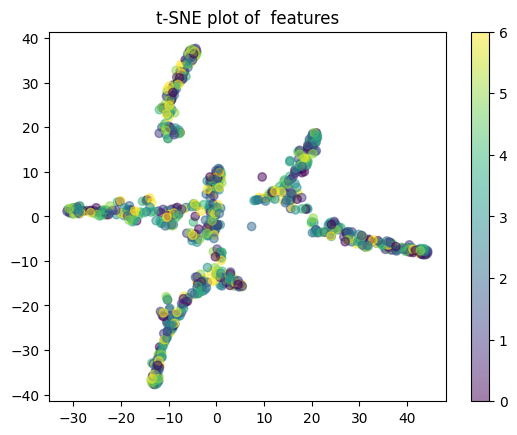

In [152]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


intermediate_output = predictions

# Initialized and fit t-SNE to our features
tsne = TSNE(n_components=2, random_state=42)
basic_test_images_tsne = tsne.fit_transform(intermediate_output)


plt.scatter(
    basic_test_images_tsne[:, 0],
    basic_test_images_tsne[:, 1],
    c=(test_generator_subset2.classes),
    cmap='viridis',
    alpha=0.5
)
plt.colorbar()
plt.title('t-SNE plot of  features')
plt.show()


**3. Random prediction**

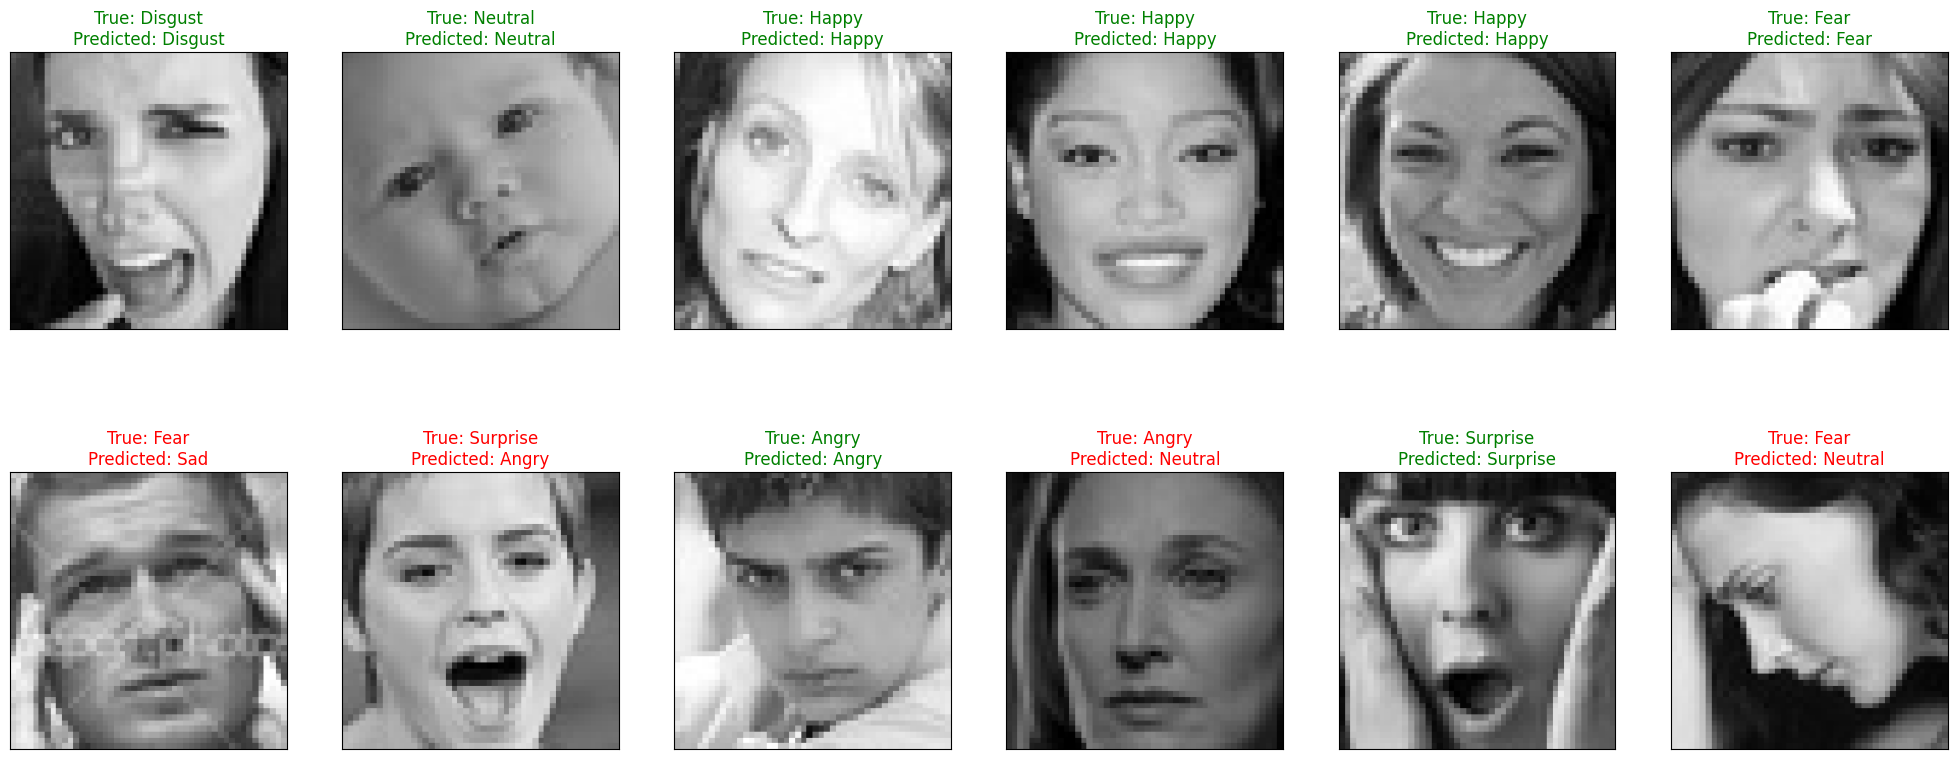

<Figure size 640x480 with 0 Axes>

In [96]:

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 12)

fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(ResNet50V2_Model2.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()

**Final Accuracy**

In [102]:
train_loss, train_acc = ResNet50V2_Model2.evaluate(train_generator_subset2)
test_loss, test_acc = ResNet50V2_Model2.evaluate(test_generator_subset2)
print("final train accuracy = {:.2f} , test accuracy = {:.2f}".format(train_acc*100, test_acc*100))

13/13 [==============================] - 3s 178ms/step - loss: 1.3021 - accuracy: 0.5586
final train accuracy = 86.98 , test accuracy = 55.86
